# Traffic tracker counting

This notebook will convert the traffic tracker object paths output into useful count data to conduct performance evaluation and dive deeper into pitfalls and problems and how to deal with them in post-processing.

### Import dependencies

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

### Read in data

In [29]:
# load object paths
df = pd.read_csv('beachhill_pednet_1.csv', header=0)
                 #, names=['frame', 'class', 'time',  'id', 'age', 'time_last_update', 'bb_left', 'bb_top', 'bb_right', 'bb_bottom'])
df.shape

(2957, 11)

In [30]:
df.sample(5)

,frame_num,rpi_time,obj_class,obj_id,obj_age,obj_t_since_last_update,obj_hits,xmin,ymin,xmax,ymax
406,48,1621977010,vehicle,2,49,0,47,557,47,627,85
2032,175,1621977067,vehicle,25,105,0,92,685,60,749,110
2249,194,1621977077,vehicle,2,195,0,193,555,45,622,88
1274,110,1621977036,vehicle,2,111,0,109,562,46,626,85
1659,139,1621977050,vehicle,8,129,4,98,573,50,635,92


In [37]:
#  compute detection centroids
df['cx'] = 0.5 * (df['xmin'] + df['xmax'])
df['cy'] = 0.5 * (df['ymin']  + df['ymax'])

In [33]:
#Curious about units of time
print(df['rpi_time'].max() - df['rpi_time'].min())
print(df['frame_num'].max() - df['frame_num'].min())

144
299


In [9]:
# load helper image
IMG_PATH = 'frame_000000.jpg'
pil_img = Image.open(IMG_PATH)

### Analysis

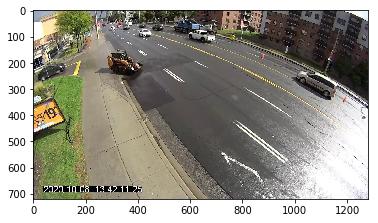

In [10]:
plt.imshow(pil_img)

In [14]:
# first, lets create a path which if crossed, will increment our counters
gates = [
    [(200,600), (850,250)],    # (xy1, xy2)
    [(875,250), (925,150)],   # (xy1, xy2)
]

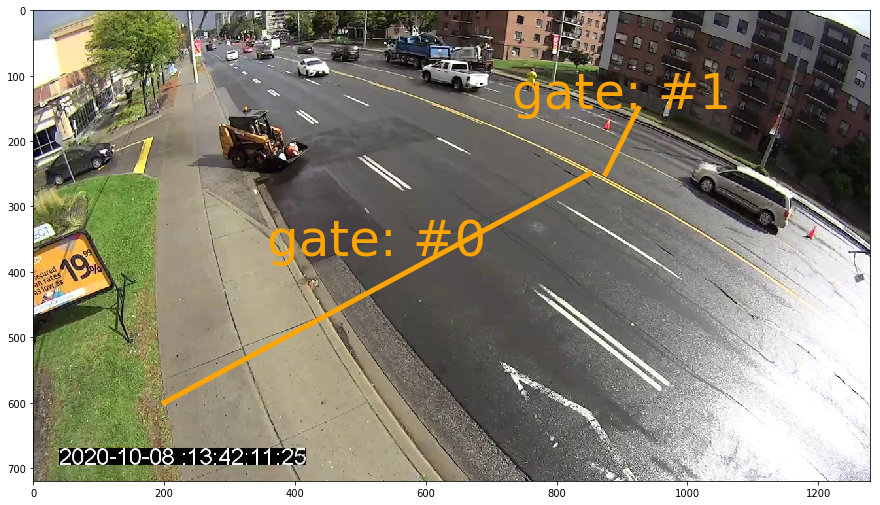

In [15]:
# let's validate that these gates are in the right place with a plot
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x1, y1 = gate[0]
    x2, y2 = gate[1]
    x, y = [x1, x2], [y1, y2]
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        "gate: #{}".format(g), 
        color='orange', 
        horizontalalignment='center',
        fontsize=50)
        
ax.set_aspect('equal')
plt.show()

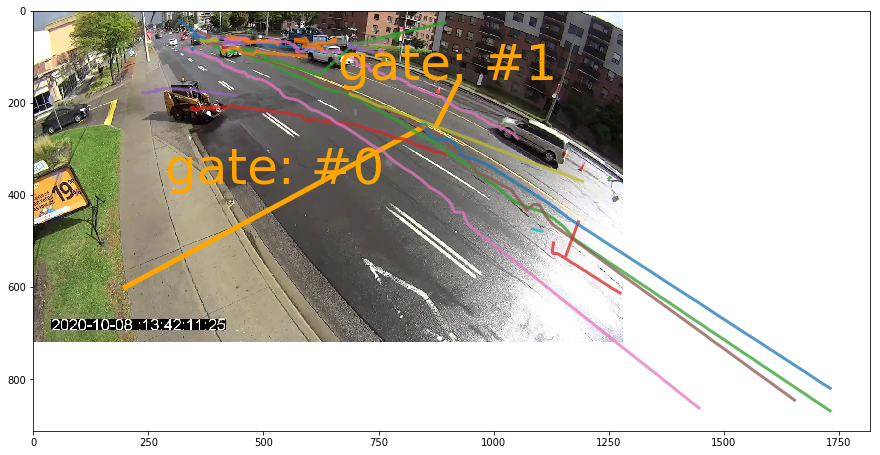

In [51]:
# Test plotting all trajectories
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x1, y1 = gate[0]
    x2, y2 = gate[1]
    x, y = [x1, x2], [y1, y2]
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        "gate: #{}".format(g), 
        color='orange', 
        horizontalalignment='center',
        fontsize=50)
        
#ax.set_aspect('equal')
for _, obj_path in df.groupby(by='obj_id'):
    ax.plot(obj_path['cx'], obj_path['cy'], lw=3, alpha=0.75)
plt.show()

The easiest way to get traffic counts from this point is to simply look at the time-dependent trajectory of each object and see if it crosses any of the gates. This means we need to create a simple function, which when given two line segments will return `True` if they cross and `False` if they don't or are only touching.

In [16]:
def ccw(a, b, c):
    return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

In [19]:
def cross(gate, trajectory):
    g_0, g_1 = gate
    t_0, t_1 = trajectory
    return ccw(g_0, t_0, t_1) != ccw(g_1, t_0, t_1) and ccw(g_0, g_1, t_0) != ccw(g_0, g_1, t_1)

In [25]:
%%time
# now lets cycle throught each objects trajectory and determine if it has crossed either of the gates
obj_path.sort_values(by=['id','time'], ascending=True, inplace=True)
obj_path['trajectory'] =  tuple(obj_path[])
gate_counts_dict = defaultdict(int)
for n, obj_path in df.groupby(by='id'):
    
    # cycle through each time step of trajectory in ascending order
    for i, row in obj_path.sort_values(by='time', ascending=True).iterrows():
    
        # get position at current time
        xy_t0 = tuple(row[['cx', 'cy']].values)
        
        # get position at most recent historic time step
        xy_t1 = obj_path[ obj_path['frame'] < row['frame']].sort_values(by='frame', ascending=False)
        
        # if a previous time step is found, let's check if it crosses any of the gates
        if xy_t1.shape[0]>0:
            xy_t1 = tuple(xy_t1[['cx', 'cy']].values[0])
            
            # cycle through gates
            for g, gate in enumerate(gates):
                gate_counts_dict[g] += cross(gates[g], [xy_t0, xy_t1])        

CPU times: user 10.6 s, sys: 66.3 ms, total: 10.6 s
Wall time: 10.7 s


In [23]:
# print some results
for k, v in gate_counts_dict.items():
    print('GATE {k}: {v}'.format(k=k, v=v))

GATE 0: 152
GATE 1: 112
